# Предсказание числа багов

## Задача

Построить модель, предсказывающую число багов в будующих пушах.

## Описание данных

Датасет описывает некоторую зависимость числа bugs от значений repository_name, commit_hash, commit_date, commit_author, commit_message. Вам необходимо выявить данную зависимость и написать скрипт/ноутбук, обучающий модель по данному датасету

## Импорт библиотек

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

In [2]:
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

In [3]:
from pymystem3 import Mystem

In [4]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [5]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alexey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Alexey\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 1. Изучение данных

In [6]:
bugs_data = pd.read_csv('train.csv', parse_dates=[2])

Откроем файл и изучим данные.

In [7]:
bugs_data.head()

,repository_name,commit_hash,commit_date,commit_author,commit_message,bugs
0,mlm,b28abb42,2020-06-12 14:26:12,Victor,объяснения предсказаний с помощью lime,4
1,mlm,438b5c4d,2020-06-12 11:53:10,Victor,Поставил lime вместо eli5,3
2,mlm,8e6e4f31,2020-06-11 15:19:03,Victor,Скрипт для создния пакетов обновления,4
3,mlm,5e0956a6,2020-06-11 10:42:29,Victor,Сортировка весов по убыванию,3
4,mlm,b9f4b40c,2020-06-11 09:25:19,Victor,не надо конвертировать массив до операции по с...,7


In [8]:
bugs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   repository_name  319 non-null    object        
 1   commit_hash      319 non-null    object        
 2   commit_date      319 non-null    datetime64[ns]
 3   commit_author    319 non-null    object        
 4   commit_message   319 non-null    object        
 5   bugs             319 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 15.1+ KB


In [9]:
bugs_data.repository_name.value_counts()

conductor    114
sensor       102
mlm           41
standard      29
dockers       19
agent         14
Name: repository_name, dtype: int64

In [10]:
bugs_data.commit_author.value_counts()

Victor     134
Mallory     67
Wendy       48
Dabe        42
Eve          9
Trudy        9
Carol        4
Alice        2
Peggy        2
Bob          2
Name: commit_author, dtype: int64

In [11]:
bugs_data.bugs.value_counts()

2     96
3     75
4     51
1     44
5     19
6     10
0      8
7      7
8      3
12     2
9      2
11     1
10     1
Name: bugs, dtype: int64

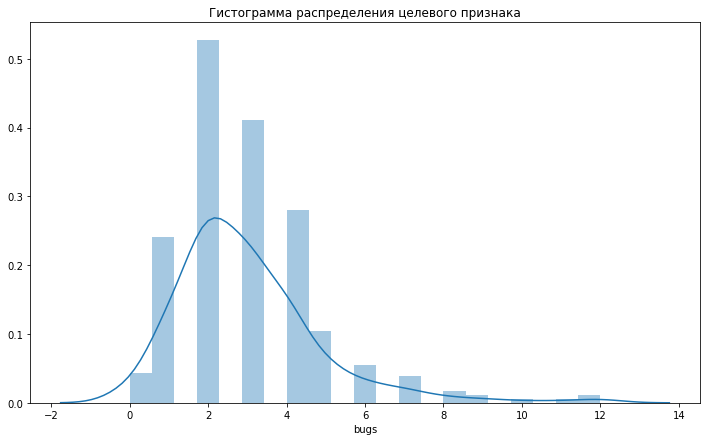

In [145]:
plt.figure(figsize=(12,7))
sns.distplot(bugs_data['bugs'])
plt.title('Гистограмма распределения целевого признака')
plt.show()

Рассмотрим зависимость `repository_name`, `commit_author` от `bugs`.

In [12]:
oe = OrdinalEncoder()
bugs_data[['repository_name', 'commit_author']] = oe.fit_transform(bugs_data[['repository_name', 'commit_author']]).astype(int)

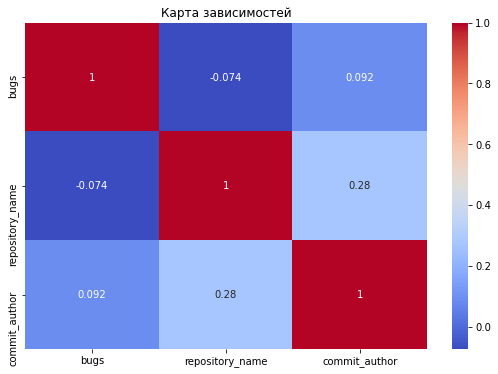

In [13]:
plt.figure(figsize=(9,6))
sns.heatmap(bugs_data[['bugs', 'repository_name', 'commit_author']].corr(), cmap='coolwarm', annot=True)
plt.title('Карта зависимостей')
plt.show()

<Figure size 720x432 with 0 Axes>

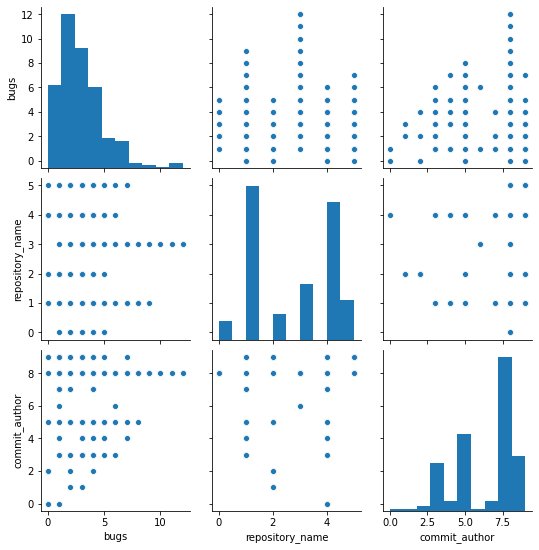

In [14]:
plt.figure(figsize=(10,6))
sns.pairplot(bugs_data[['bugs', 'repository_name', 'commit_author']])
plt.show()

### Вывод

На графиках видно, что зависимость `bugs` от `repository_name` и `commit_author` практически отсутсвует. Для обучения модели эти признаки нельзя использовать.

Признаки `commit_hash` и `commit_date` являются уникальными для каждой строки.

Таким образом в обучении будет использован только `commit_message`.

## 2. Предобработка данных

Создадим датасет, состоящий из `commit_message` и `bugs`.

In [15]:
before_training_bugs_data = bugs_data[['commit_message', 'bugs']].copy()

In [16]:
before_training_bugs_data.head(10)

,commit_message,bugs
0,объяснения предсказаний с помощью lime,4
1,Поставил lime вместо eli5,3
2,Скрипт для создния пакетов обновления,4
3,Сортировка весов по убыванию,3
4,не надо конвертировать массив до операции по с...,7
5,Добавлено больше логирования и фикс до частичн...,6
6,"Отладка, чтоб оно хотябы запускалось",4
7,Добавил скрипт для запуска контейнера,4
8,label не нужен,2
9,Установка всех зависимостей теперь в докер файле,5


Выделим признаки из текста.

Изучим зависимость количества багов от длинны коммитов.

In [17]:
commit_len = []
for i in range(len(before_training_bugs_data)):
    commit_len.append(len(before_training_bugs_data['commit_message'][i].split()))

    
before_training_bugs_data.loc[:, 'commit_len'] = commit_len

In [18]:
before_training_bugs_data.head()

,commit_message,bugs,commit_len
0,объяснения предсказаний с помощью lime,4,5
1,Поставил lime вместо eli5,3,4
2,Скрипт для создния пакетов обновления,4,5
3,Сортировка весов по убыванию,3,4
4,не надо конвертировать массив до операции по с...,7,9


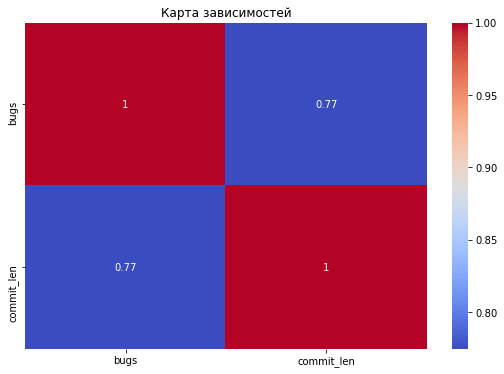

In [19]:
plt.figure(figsize=(9,6))
sns.heatmap(before_training_bugs_data.corr(), cmap='coolwarm', annot=True)
plt.title('Карта зависимостей')
plt.show()

Можно увидеть, что у `bugs` и `commit_len` высокая корреляция и равняется 0.77. На этот признак стоит обратить внимание.

Лемматизируем текст. Для этого используем библиотеку `pymystem3` для русского и `spacy` для анлийского языка.

In [20]:
def lemmatizing_sentences(sentence):
    m = Mystem()
    token_list = []
    sentence = ''.join(m.lemmatize(sentence))
    
    for token in nlp(sentence):
        token_list.append(token.lemma_)
        for trash_word in (['-PRON-', ':', '\n', '.', ',', '!', '?', '\"', '\n\n', '-', '>', ';']):
            if token.lemma_ == trash_word:
                token_list.remove(trash_word)
    
    return ' '.join(token_list)

In [21]:
%%time
before_training_bugs_data['lemmatized_commit_message'] = before_training_bugs_data['commit_message'].apply(lemmatizing_sentences)

Wall time: 4min 1s


In [22]:
before_training_bugs_data

,commit_message,bugs,commit_len,lemmatized_commit_message
0,объяснения предсказаний с помощью lime,4,5,объяснение предсказание с помощь lime
1,Поставил lime вместо eli5,3,4,поставлять lime вместо eli5
2,Скрипт для создния пакетов обновления,4,5,скрипт для создний пакет обновление
3,Сортировка весов по убыванию,3,4,сортировка весы по убывание
4,не надо конвертировать массив до операции по с...,7,9,не надо конвертировать массив до операция по с...
...,...,...,...,...
314,setting hostname,1,2,set hostname
315,heralding default dockerfile,2,3,herald default dockerfile
316,unnesserity /data path permissions setting,3,5,unnesserity /data path permission set
317,added trapconductor,1,2,add trapconductor


Теперь мы можем выделить еще признаки, которые могут показывать наличие или отсутсвие багов.

*(В данной задаче можно было бы применить BERT, но, я считаю, что он избыточен. На Git, обычно, пушат с небольшим комментарием, где кратео излагают свои действия. BERT же хорош, но очень громоздкий для данной задачи.)*

In [23]:
before_training_bugs_data['bug_word'] = [1 if i >=0 else 0 for i in before_training_bugs_data['lemmatized_commit_message'].str.find('bug')]
before_training_bugs_data['fix_word'] = [1 if i >=0 else 0 for i in before_training_bugs_data['lemmatized_commit_message'].str.find('fix')]
before_training_bugs_data['mistake_ru_word'] = [1 if i >=0 else 0 for i in before_training_bugs_data['lemmatized_commit_message'].str.find('ошибка')]

In [101]:
before_training_bugs_data.head(10)

,commit_message,bugs,commit_len,lemmatized_commit_message,bug_word,fix_word,mistake_ru_word
0,объяснения предсказаний с помощью lime,4,5,объяснение предсказание с помощь lime,0,0,0
1,Поставил lime вместо eli5,3,4,поставлять lime вместо eli5,0,0,0
2,Скрипт для создния пакетов обновления,4,5,скрипт для создний пакет обновление,0,0,0
3,Сортировка весов по убыванию,3,4,сортировка весы по убывание,0,0,0
4,не надо конвертировать массив до операции по с...,7,9,не надо конвертировать массив до операция по с...,0,0,0
5,Добавлено больше логирования и фикс до частичн...,6,8,добавлять много логирование и фикс до частичны...,0,0,0
6,"Отладка, чтоб оно хотябы запускалось",4,5,отладка чтоб оно хотяб запускаться,0,0,0
7,Добавил скрипт для запуска контейнера,4,5,добавлять скрипт для запуск контейнер,0,0,0
8,label не нужен,2,3,label не нужный,0,0,0
9,Установка всех зависимостей теперь в докер файле,5,7,установка весь зависимость теперь в докер файл,0,0,0


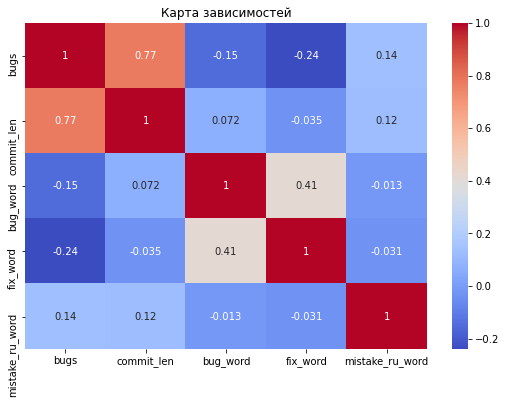

In [25]:
plt.figure(figsize=(9,6))
sns.heatmap(before_training_bugs_data.corr(), cmap='coolwarm', annot=True)
plt.title('Карта зависимостей')
plt.show()

На катре корреляций видно, что выделенные признаки имеют очень слабую корреляцию. Однако, они могут помочь найти некоторые очевидные данные.

## 3. Обучени модели

Разделим датасет на три выборки - тренировочную, валидационную и тестовую.

In [87]:
train, test = train_test_split(before_training_bugs_data.drop(['commit_message', 'lemmatized_commit_message'], axis=1), test_size=0.4, random_state=132)

In [88]:
test ,valid = train_test_split(test, test_size=0.5, random_state=132)

In [89]:
train_target, test_target, valid_target = train['bugs'], test['bugs'], valid['bugs']
train_features, test_features, valid_features = train.drop('bugs',axis=1), test.drop('bugs',axis=1), valid.drop('bugs',axis=1) 

Обучим модель случайного леса.

*(гипперпараметры и сама модель были подобраны с использованием GridSearchCV в другом файле, чтобы не переполнять этот. Я его не выкладываю, но могу продемонстрировать.)*

In [151]:
model = RandomForestRegressor(random_state=12, n_jobs=-1, n_estimators=100, max_depth=4)
model.fit(train_features, train_target)

RandomForestRegressor(max_depth=4, n_jobs=-1, random_state=12)

In [156]:
prediction = model.predict(valid_features).round()

In [157]:
compare_target_valid = pd.concat([valid_target.reset_index(drop=True),pd.Series(prediction)], axis=1)
compare_target_valid.columns = ['bugs','prediction']

Text(0.5, 1.0, '')

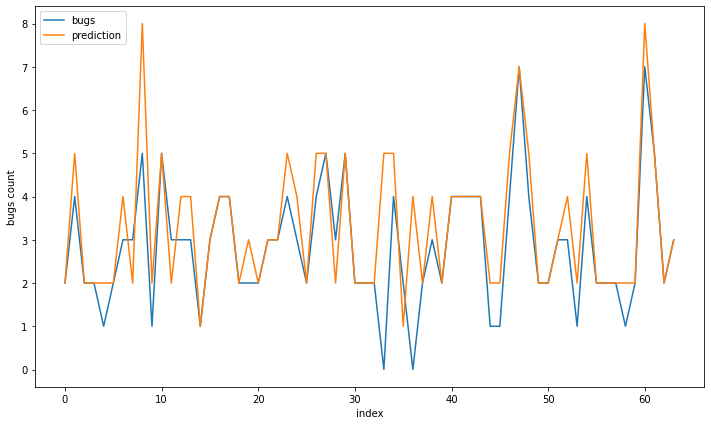

In [158]:
compare_target_valid.plot(figsize=(12,7))
plt.xlabel('index')
plt.ylabel('bugs count')
plt.title('')

In [159]:
valid_rmse = mean_squared_error(valid_target, prediction)**0.5
valid_rmse

1.0825317547305484

### Вывод

На валидационной выборке было достигнуто значение rmse равное 1.08. Это значит, что модель в среднем ошибается на единицу. Я считаю, что это хороший результат.

## 4. Проверка на тестовой выборке.

Для проверки на тестовой выборке обучим модель снова на объединенных тестовой и валидационной выборке.

In [161]:
model.fit(pd.concat([train_features, valid_features]), pd.concat([train_target, valid_target]))

RandomForestRegressor(max_depth=4, n_jobs=-1, random_state=12)

In [162]:
prediction = model.predict(test_features).round()

In [163]:
compare_target_test = pd.concat([test_target.reset_index(drop=True),pd.Series(prediction)], axis=1)
compare_target_test.columns = ['bugs','prediction']
compare_target_test.head(10)

,bugs,prediction
0,3,3.0
1,3,3.0
2,5,7.0
3,2,2.0
4,3,4.0
5,4,4.0
6,1,2.0
7,4,4.0
8,4,5.0
9,1,2.0


Text(0, 0.5, 'bugs count')

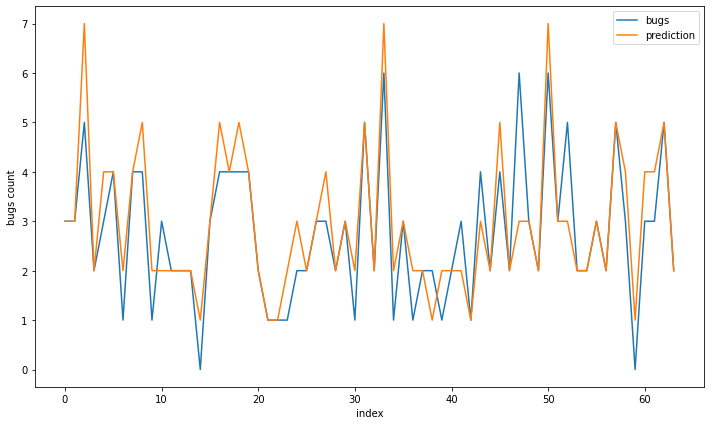

In [164]:
compare_target_test.plot(figsize=(12,7))
plt.xlabel('index')
plt.ylabel('bugs count')

In [168]:
test_rmse = mean_squared_error(test_target, prediction)**0.5
test_rmse

0.8100925873009825

RMSE на тестовой выборке получился равен 0.81. 

Проверим модель на адекватность. Для этого используем Dummy модель.

In [172]:
dummy_model = DummyRegressor()
dummy_model.fit(pd.concat([train_features, valid_features]), pd.concat([train_target, valid_target]))

DummyRegressor()

In [173]:
dummy_prediction = dummy_model.predict(test_features).round()

In [174]:
compare_target_test = pd.concat([compare_target_test, pd.Series(dummy_prediction)], axis=1)
compare_target_test.columns = ['bugs','prediction', 'dummy_prediction']
compare_target_test.head(10)

,bugs,prediction,dummy_prediction
0,3,3.0,3.0
1,3,3.0,3.0
2,5,7.0,3.0
3,2,2.0,3.0
4,3,4.0,3.0
5,4,4.0,3.0
6,1,2.0,3.0
7,4,4.0,3.0
8,4,5.0,3.0
9,1,2.0,3.0


Text(0, 0.5, 'bugs count')

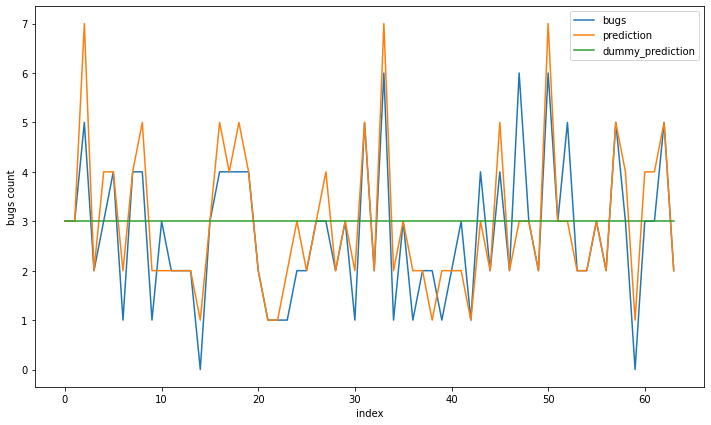

In [175]:
compare_target_test.plot(figsize=(12,7))
plt.xlabel('index')
plt.ylabel('bugs count')

In [177]:
dummi_rmse = mean_squared_error(test_target, dummy_prediction)**0.5
dummi_rmse

1.4415703243338496

### Выводы

RMSE на тестовой выборке получился равен 0.81, тогда как на dummi модел дала результат, равный 1.44. Это говорит о том, что модель имеет смысл и может быть использованна для предсказания реальных данных. 

## 5. Общие выводы

Задача стояла разработать модель, которая предсказывавала число багов. Из начальных данных были удалены все столбцы, кроме столбцов с коммитами. Также было найдено, что число багов сильно зависит от числа слов в пуше. Далее были в ручную выделенны еще 3 зависимости из текста для улучшения результата модели. 

Модель была выбрана случайный лес. В результате удалось достигнуть результат RMSE на тестовой выборке равный 0.81. Это на 0.63 лучше результата средней модели (dummy_model).

Я бы рекомендовал расширить набор данных для улучшения качества предсказания.